# Defacing pre-registration - Statistical analysis on manual ratings in R

## Load simulated manual ratings

In [24]:
df_full <- readRDS(file="SimulatedData/SimulatedDefacedRatings_noMissing_12raters.Rda")
df_missing <- readRDS(file="SimulatedData/SimulatedDefacedRatings_10%Missing.Rda")

#Define the number of raters in the dataset
n_rater = length(unique(df_full$rater))

In [2]:
source("simulate_data.R")

The simulated data were generated by running the `simulate_data.R` function.

## Linear mixed effect regression

Because the continuation ratio model implementation could not deal with missing values, we are switching to linear mixed effect regression model. It has been shown that considering linear regression on ordinal data is ok, as long as the probabilities of belonging to each category are far from the extremes.

### Do I need interaction terms in my model ?

We use an interaction plot to figure if an interaction between the defacing status and the rater is present. If the lines are not parallel, an interaction exists. Plot construction based on https://stattrek.com/multiple-regression/interaction.

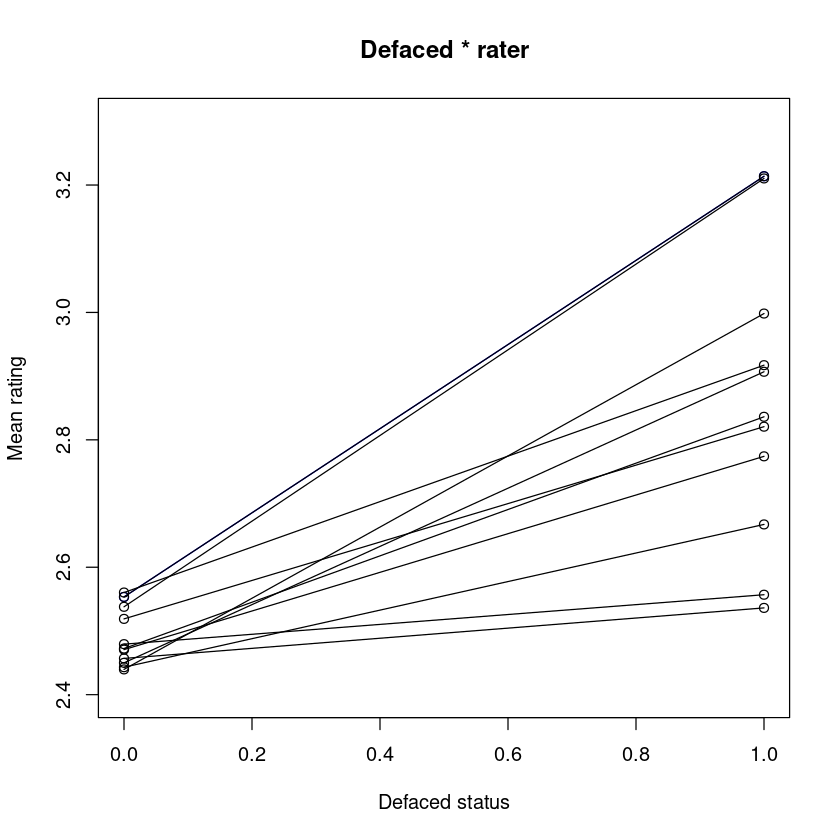

In [26]:
#Compute mean rating for each rater and each condition
mean_defaced = c()
mean_original = c()
for (i in 1:n_rater){
    df_small_defaced <- subset(df_full, defaced == 'defaced' & rater == sprintf('rater%02d', i))
    df_small_original <- subset(df_full, defaced == 'original' & rater == sprintf('rater%02d', i))
    mean_defaced[i] <- mean(as.numeric(df_small_defaced$ratings))
    mean_original[i] <- mean(as.numeric(df_small_original$ratings))
}

#Interaction plot
plot(c(0,1), c(mean_original[i], mean_defaced[i]),
    ylab="Mean rating",
    xlab="Defaced status",
    main ='Defaced * rater',
    ylim = c(2.4,3.3),
    type="o",
    col="blue")
for (i in 2:n_rater){ 
    lines(c(0,1), c(mean_original[i], mean_defaced[i]), type='o')
}

In the plot above, one line represents the evolution of the mean rating before and after defacing for one rater. The lines are not parallel, so we have to include the interaction term into the model. I interpret it as different raters are differently biased by the defacing process.
BUT we need to reduce the number of raters, because too many raters implies too many coefficients to estimate, hence the model doesn't converge.

We see two ways of including the interaction defaced/rater in the model, via fixed effects or via random slope. Below we try both models to figure out which makes more sense.

### First possible model

The first possible model is to allow for random intercept and slope for each rater.

In [45]:
## Load data
n_rated <- 580
n_sub <- 580 #nbr of subjects available in the dataset
n_rater <- 20 #nbr of raters
#perc_biased <- c(2,40,60,90) #4 raters + bias
perc_biased <- rep(c(2,20,40,40,40,40,60,60,60,80), times = n_rater/10)

df_4 <- simulate_data(n_rated, n_sub, n_rater, perc_biased)

## Fit model
library(lme4)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (defaced | rater), data=df_4)
summary(fm1)
ranef(fm1)

Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(ratings) ~ defaced + (defaced | rater)
   Data: df_4

REML criterion at convergence: 69765.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9341 -0.7501  0.1476  0.9985  1.3987 

Random effects:
 Groups   Name           Variance Std.Dev. Corr
 rater    (Intercept)    0.000081 0.0090       
          defaceddefaced 0.023183 0.1523   1.00
 Residual                1.181217 1.0868       
Number of obs: 23200, groups:  rater, 20

Fixed effects:
               Estimate Std. Error t value
(Intercept)     2.49716    0.01029 242.684
defaceddefaced  0.33328    0.03692   9.028

Correlation of Fixed Effects:
            (Intr)
defaceddfcd -0.088

$rater
          (Intercept) defaceddefaced
rater01 -0.0137121026   -0.231982046
rater02 -0.0116519517   -0.197128006
rater03 -0.0047464350   -0.080300170
rater04 -0.0027491906   -0.046510765
rater05 -0.0019479755   -0.032955895
rater06 -0.0014683224   -0.024841151
rater07  0.0073752578    0.124774827
rater08  0.0047104721    0.079691991
rater09  0.0023763537    0.040203546
rater10  0.0147206981    0.249045313
rater11 -0.0172770137   -0.292293108
rater12 -0.0079682654   -0.134807541
rater13 -0.0021358638   -0.036134583
rater14 -0.0009344548   -0.015809158
rater15 -0.0008500295   -0.014380958
rater16  0.0005094707    0.008619085
rater17  0.0036568083    0.061866280
rater18  0.0058328356    0.098680108
rater19  0.0110986736    0.187767386
rater20  0.0151610351    0.256494842

with conditional variances for “rater” 

#### Continuous ratings

The problem is that this model converges to a singular solution. Thus we want to see if switching to continuous ratings solves this issue.

In [39]:
## Simulate continuous data with bias

n_rated <- 580
n_sub <- 580 #nbr of subjects available in the dataset
n_rater <- 20 #nbr of raters
#perc_biased <- c(2,40,60,90) #4 raters + bias
perc_biased <- rep(c(2,20,40,40,40,40,60,60,60,80), times = n_rater/10)
ratings_range <- seq(0,1,length.out=11)
labels <- c('excluded','0.1','poor','0.3','acceptable','0.5','good','0.7','very good','0.9','excellent')
bias <- 0.2

df_cont <- simulate_data(n_rated, n_sub, n_rater, perc_biased, ratings_range=ratings_range, labels=labels, bias=bias)

## Fit model
library(lme4)
fm1_cont <- lmer(as.numeric(ratings) ~ defaced + (defaced | rater), data=df_cont)
summary(fm1_cont)
ranef(fm1_cont)

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(ratings) ~ defaced + (defaced | rater)
   Data: df_cont

REML criterion at convergence: 118696

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.08173 -0.90876 -0.00164  0.93596  1.63773 

Random effects:
 Groups   Name           Variance Std.Dev. Corr
 rater    (Intercept)    0.004894 0.06996      
          defaceddefaced 0.120293 0.34683  1.00
 Residual                9.737214 3.12045      
Number of obs: 23200, groups:  rater, 20

Fixed effects:
               Estimate Std. Error t value
(Intercept)     6.04060    0.03293 183.461
defaceddefaced  0.76871    0.08771   8.764

Correlation of Fixed Effects:
            (Intr)
defaceddfcd 0.129 
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular


$rater
         (Intercept) defaceddefaced
rater01 -0.122559986   -0.607634720
rater02 -0.076208795   -0.377832205
rater03 -0.004325816   -0.021446772
rater04 -0.002859421   -0.014176598
rater05  0.000611086    0.003029676
rater06 -0.021493377   -0.106561061
rater07  0.045332251    0.224750755
rater08  0.037817120    0.187491825
rater09  0.058122466    0.288162795
rater10  0.115245200    0.571369068
rater11 -0.151062286   -0.748945011
rater12 -0.064104045   -0.317818601
rater13  0.017955018    0.089018386
rater14 -0.008094963   -0.040133659
rater15 -0.035485430   -0.175931642
rater16  0.004436155    0.021993817
rater17  0.043865856    0.217480581
rater18  0.048335027    0.239638086
rater19  0.011848045    0.058740899
rater20  0.102625896    0.508804381

with conditional variances for “rater” 

#### Use bayesian modelling

In [10]:
library(brms)

n_rated <- 20
n_sub <- 20 #nbr of subjects available in the dataset
n_rater <- 4 #nbr of raters
perc_biased <- c(2,40,60,90) #4 raters + bias

source("simulate_data.R")

df_bay <- simulate_data(n_rated, n_sub, n_rater, perc_biased)

fm1_bay <- brm(as.numeric(ratings) ~ defaced + (1 | rater), data=df_bay, family=cratio("logit"))
summary(fm1_bay)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL '5d339adcbc97bf62b3667a147352622e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.18429 seconds (Warm-up)
Chain 1:                1.28007 seconds (Sampling)
Ch

Warning message:
“There were 5 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”
Warning message:
“There were 5 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: cratio 
  Links: mu = logit; disc = identity 
Formula: as.numeric(ratings) ~ defaced + (1 | rater) 
   Data: df_bay (Number of observations: 160) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~rater (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.29      0.31     0.01     1.17 1.01      658      338

Population-Level Effects: 
               Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept[1]      -1.51      0.30    -2.09    -0.90 1.00     1125      628
Intercept[2]      -0.73      0.28    -1.27    -0.17 1.01     1183      535
Intercept[3]       0.37      0.30    -0.21     0.99 1.01      980      392
defaceddefaced     0.51      0.24     0.03     0.96 1.00     3277     2146

Family Specific Parameters: 
     Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
disc     1.00      0.00     1.00     1

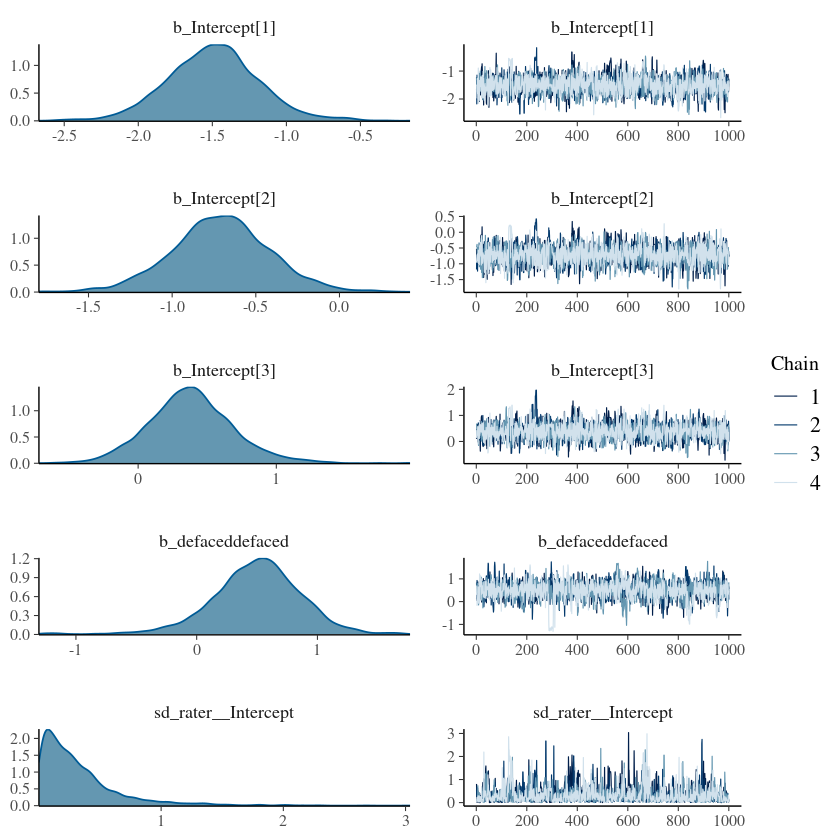

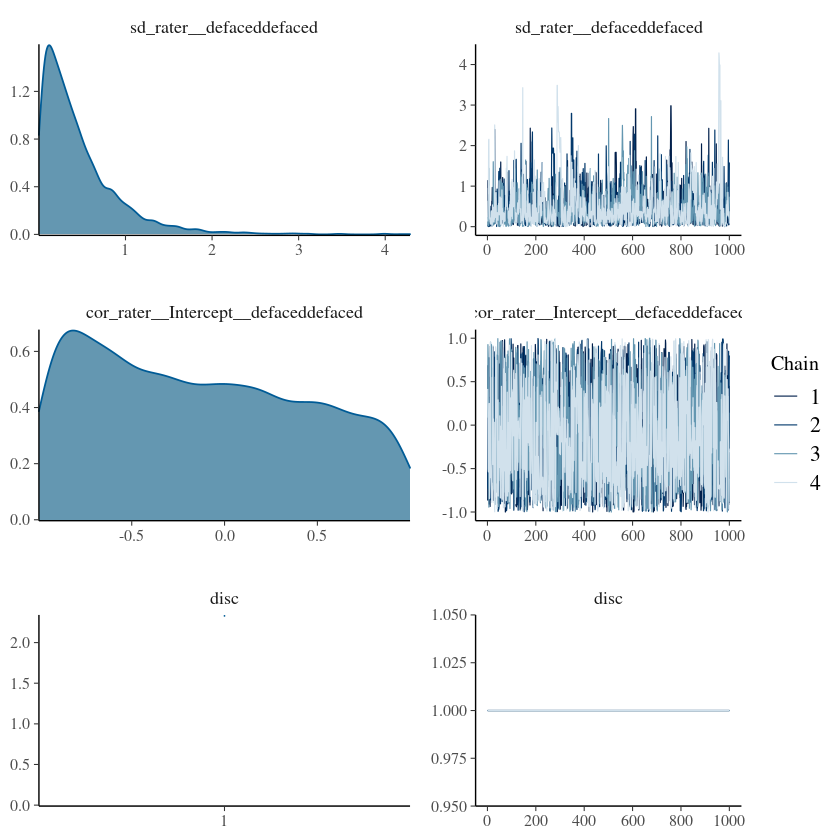

In [9]:
plot(fm1_bay)

#### Visualize random effects

We extract the regression coefficients and overlay the resulting regression lines on the data to get a sense of the data fit

In [31]:
# see group coefficients
# see group coefficients
model_coefs <- coef(fm1_cont)$rater %>%
  rename(Intercept = `(Intercept)`, Slope = defaceddefaced) %>% 
  rownames_to_column("rater")

# see coefficients
model_coefs

ERROR: Error in coef(fm1_cont)$rater %>% rename(Intercept = `(Intercept)`, Slope = defaceddefaced) %>% : could not find function "%>%"


First, we’ll join these coefficients to our original data so we can plot the individual lines.

In [32]:
library(tidyverse)
fm1_groups <- left_join(df_cont, model_coefs, by = "rater")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()



ERROR: Error in is.data.frame(y): object 'model_coefs' not found


In [35]:
library(ggplot2)
model_coef_plot <- ggplot(data = fm1_groups, 
       mapping = aes(x = defaced, 
                     y = ratings, 
                     colour = rater)
       ) +
  geom_point(na.rm = T, alpha = 0.5) +
  geom_abline(aes(intercept = Intercept, 
                  slope = Slope,
                  colour = rater
                  ),
              size = 1.5
              ) +
  theme(legend.position = "top")

# see the plot
model_coef_plot

ERROR: Error in ggplot(data = fm1_groups, mapping = aes(x = defaced, y = ratings, : object 'fm1_groups' not found


### Second possible model

The second possible model is to include the interaction defaced*rater as a fixed effect.

In [36]:
## Second possible model
fm2 <- lmer(as.numeric(ratings) ~ defaced*rater + (1 | rater), data=df_4)
summary(fm2)
ranef(fm2)


Correlation matrix not shown by default, as p = 40 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(ratings) ~ defaced * rater + (1 | rater)
   Data: df_4

REML criterion at convergence: 69838.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9528 -0.7472  0.1491  0.9915  1.4578 

Random effects:
 Groups   Name        Variance  Std.Dev.
 rater    (Intercept) 0.0004751 0.0218  
 Residual             1.1813072 1.0869  
Number of obs: 23200, groups:  rater, 20

Fixed effects:
                             Estimate Std. Error t value
(Intercept)                  2.544828   0.050119  50.776
defaceddefaced               0.017241   0.063824   0.270
raterrater02                -0.087931   0.070878  -1.241
raterrater03                -0.100000   0.070878  -1.411
raterrater04                -0.086207   0.070878  -1.216
raterrater05                -0.055172   0.070878  -0.778
raterrater06                -0.043103   0.070878  -0.608
raterrater07                -0.031034   0.070878  -0.438
raterrater08                -0

$rater
          (Intercept)
rater01 -1.317914e-14
rater02 -1.647392e-14
rater03 -1.694460e-14
rater04 -1.682693e-14
rater05 -1.482653e-14
rater06 -1.376749e-14
rater07 -1.706227e-14
rater08 -1.659159e-14
rater09 -1.600324e-14
rater10 -1.400283e-14
rater11 -1.576790e-14
rater12 -1.706227e-14
rater13 -1.694460e-14
rater14 -1.706227e-14
rater15 -1.870967e-14
rater16 -1.835665e-14
rater17 -1.553255e-14
rater18 -1.635625e-14
rater19 -1.788597e-14
rater20 -1.682693e-14

with conditional variances for “rater” 

#### Visualize fixed effect regression coefficients

In [33]:
library(coefplot2)
coefplot2(fm2)

Loading required package: coda



ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'coefplot2': object 'fm2' not found


The thick bars correspond to ±1SD or 50% credible intervals and the thin lines to ±2SD or 95% CI

### Which formula ?

I am not sure whether we should include the interaction between defaced and rater as an interaction term in the fixed effect or as a random slope in the random effects.
Therefore I'm running an log likelihood ratio test to compare both models.

In [37]:
anova(fm1, fm2)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm1,6,69765.09,69813.40,-34876.54,69753.09,NA,NA,NA
fm2,42,69748.34,70086.52,-34832.17,69664.34,88.74922,36,2.39641e-06


For AIC and BIC smaller is better; for log-likelihood higher is better; chi2 and p-value should be significant for the model to be significantly better. Thus, including the interaction term has a mixed effect seems to model the data better.

### Test for significance

To test whether defacing significantly biases the human ratings, we compute p-values associated with its regression coefficient. The p-value is computed using Satterthwaite approximation for degrees of freedom. You can find the justification of why we chose to test significance using Satterthwaite approximation in the following paper : https://link.springer.com/article/10.3758/s13428-016-0809-y#appendices.

In [ ]:
library(lmerTest)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (defaced | rater), data=df_full)
anova(fm1)
summary(fm1)

### How to deal with missing values

List the different options available to deal with missing values.

In [ ]:
getOption("na.action")

In [ ]:
library(lme4)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (1 | rater), data=df_missing, na.action=na.exclude)
summary(fm1)
ranef(fm1)

### Verify that the null hypothesis is not rejected if no bias has been introduced

In [ ]:
## Simulate data without bias
n_rated <- 580
n_sub <- 580 #nbr of subjects available in the dataset
n_rater <- 4 #nbr of raters
perc_biased <- c(0.5,0.5,0,0) #4 raters + no bias
file_name="SimulatedData/SimulatedDefacedRatings_4raters_nobias.Rda"

df_4_no_bias <- simulate_data(n_rated, n_sub, n_rater, perc_biased, file=file_name)

## Lmer should not find significant result
libray(lme4)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (defaced | rater), data=df_4_no_bias)
summary(fm1)
ranef(fm1)